In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


# Get all the helper functions from github

In [1]:
import os
import re
import json

import pandas as pd

from fuzzywuzzy import fuzz
from pathlib import Path
# make sure you installed fuzzywuzzy and python-Levenshtein

class results():

    def __init__(self, filename = None):
        if not filename:
            filename = input('You did not pass in file name, please input your file name (please include .json as file extension)')
            while filename.search('\.(json)$', filename) == None:
                filename = input('Your input does not contain .json as file extension. Please input correct file name')

#         self.filepath = os.path.join(Path(__file__).parents[1], 'results', filename)
        self.filepath = filename
        print(self.filepath)
        try:
            with open(self.filepath, 'x+') as results:
                print("File do not exist, creating file now")
                self.results = {
                    "experiment": []
                }
                self.df = pd.json_normalize(self.results, record_path=['experiment'], max_level=0)
        except FileExistsError:
            with open(self.filepath, 'r') as results:
                print("file exist, reading json")
                self.results = json.load(results)
                self.df = pd.json_normalize(self.results, record_path=['experiment'], max_level=0)
        

    def save(self, model = None, dataset = None, phase = None, results = None, additional = None, repeat = False):
        if model == None:
            return ValueError('Model name cannot be empty')
        if dataset == None:
            return ValueError('Dataset name cannot be empty')
        if phase == None:
            return ValueError('Phase name cannot be empty')
        if results == None:
            return ValueError('Results cannot be empty. If no results, please pass in \{\} instead')

        allLower = [f"{x['model'].lower()}_{x['dataset'].lower()}_{x['phase'].lower()}" for x in self.results['experiment']]

        if f'{model.lower()}_{dataset.lower()}_{phase.lower()}' not in allLower:
            res = {}
            res['model'] = model
            res['dataset'] = dataset
            res['phase'] = phase
            res['result'] = results
            if additional:
                res = {**res, **additional}

            temp_df = pd.DataFrame([res])
            self.df = pd.concat([self.df, temp_df])
        else:
            if repeat:
                self.df = self.df.drop(
                    self.df[
                        (self.df['model'] == model) &
                        (self.df['dataset'] == dataset) &
                        (self.df['phase'] == phase)
                    ].index
                )
                res = {}
                res['model'] = model
                res['dataset'] = dataset
                res['phase'] = phase
                res['result'] = results
                if additional:
                    res = {**res, **additional}

                temp_df = pd.DataFrame([res])
                self.df = pd.concat([self.df, temp_df])
                # print(f'Test {test} is already in record, proceed to override.')
            else:
                ans = input(f'Model {model} using dataset {dataset} and phase {phase} is already in record, would you like to override? (y/n)')
                while ans.lower() not in ['y', 'n', 'yes', 'no']:
                    ans = input(f'answer {ans} invalid, please choose (y/n)')
                if ans.lower() in ['y', 'yes']:
                    self.df = self.df.drop(
                        self.df[
                            (self.df['model'] == model) &
                            (self.df['dataset'] == dataset) &
                            (self.df['phase'] == phase)
                        ].index
                    )
                    res = {}
                    res['model'] = model
                    res['dataset'] = dataset
                    res['phase'] = phase
                    res['result'] = results
                    if additional:
                        res = {**res, **additional}

                    temp_df = pd.DataFrame([res])
                    self.df = pd.concat([self.df, temp_df])
                else:
                    print('Do not override, test result not saved')
                    return

        temp_result = self.df.to_json(orient="records")
        self.results['experiment'] = json.loads(temp_result)

        with open(self.filepath, 'w') as outfile:
            json.dump(self.results, outfile, indent=4)
            print('record saved')

    def checkIfTestExist(self, model = None, dataset = None, phase = None):
        if model == None:
            return ValueError('Model name cannot be empty')
        if dataset == None:
            return ValueError('Dataset name cannot be empty')
        if phase == None:
            return ValueError('Phase name cannot be empty')

        allLower = [f"{x['model'].lower()}\{x['dataset'].lower()}\{x['phase'].lower()}" for x in self.results['experiment']]
        search = f'{model.lower()}\{dataset.lower()}\{phase.lower()}'
        curTest = []
        for test in allLower:
            if fuzz.token_sort_ratio(test, search) >= 50:
                curTest.append((test, fuzz.token_sort_ratio(test, search)))
        
        curTest = sorted(curTest, key=lambda x: x[1], reverse=True)
        if len(curTest) == 0:
            print('Cannot find any similar test')
            return
        else:
            print('Found the following similar tests: ...')
            for t in curTest:
                temp = t[0].split('\\')
                print('-------------------------------')
                print(f'model: {temp[0]}')
                print(f'dataset: {temp[1]}')
                print(f'phase: {temp[2]}')

    
    def refresh(self, returnDict = True):
        with open(self.filepath) as results:
            self.results = json.load(results)
            self.df = pd.json_normalize(self.results, record_path=['experiment'], max_level=0)

        if returnDict:
            return self.results
        else:
            return self.df

    def unnestDataframeLevel(self, level = 0):
        return pd.json_normalize(self.results, record_path=['experiment'], max_level=level)

    def printExistingTests(self):
        if len(self.results['experiment']) == 0:
            print('There are currently no tests')
        else:
            for test in self.results['experiment']:
                print('-------------------------------')
                print(f'model: {test["model"]}')
                print(f'dataset: {test["dataset"]}')
                print(f'phase: {test["phase"]}')

    # def getExistingTests(self):
    #     if len(self.results.keys()) == 0:
    #         print('There are currently no tests')
    #     else:
    #         return [test for test in self.results]

    def getAllResults(self):
        if len(self.results.keys()) == 0:
            print('There are currently no tests')
        return self.results['experiment']

    def getDataframe(self):
        return self.df


    # def getResultRanked(self, metricName = None):
    #     if metricName == None:
    #         return ValueError('Metric name cannot be empty')

    #     s = []
    #     noRes = []

    #     if len(self.results.keys()) == 0:
    #         print('There are currently no tests')
    #         return

    #     for test in self.results:
    #         if metricName in self.results[test]['results']:
    #             metricVal = self.results[test]['results'][metricName]
    #             s.append((test, metricVal))
    #         else:
    #             metricVal = 'Record does not exist'
    #             noRes.append((test, metricVal))

    #     s = sorted(s, key=lambda x: x[1], reverse=True)
    #     noRes = sorted(noRes, key=lambda y: y[0].lower())

    #     return s + noRes

C:\Users\Tony\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef
from sklearn.utils.class_weight import compute_sample_weight

def make_confusion_matrix(
    y_true,
    y_pred=None,  # optionally pass in precalculated y predictions
    model=None,  # optionally pass in a model (along with x) to autogenerate y_pred
    x=None,  # optionally pass in a feature set (along with model) to autogenerate y_pred
    normalize="true",  # parameter for the sklearn confusion matrix function specifying how to normalize the values
    sample_weight=None,  # optionally provide precalculated sample weights
    autoweight_sample=True,  # generate sample weights automatically before calculating matrix
    print_heatmap=True,  # print the heatmap for confusion matrix
    label_names=None,  # optionally provide an explicit list of label names for the heatmap
    label_encoder=None,  # a label encoder for the to automatically get the label names
    figsize=(9, 9),  # size of the heatmap displayed
    title=None,  # printed title of the heatmap
):

    # resolve polymorphisms / optional values
    y_pred = resolve_y_pred(y_pred=y_pred, model=model, x=x,)
    sample_weight = resolve_sample_weight(y_true, sample_weight, autoweight_sample)
    label_names = resolve_label_names(
        y_true,
        y_pred,
        model=model,
        label_names=label_names,
        label_encoder=label_encoder,
    )

    # calculate the confusion matrix
    cm = confusion_matrix(
        y_true=y_true, y_pred=y_pred, normalize=normalize, sample_weight=sample_weight,
    )

    # print a heatmap
    if print_heatmap:
        plt.figure(figsize=figsize, facecolor="white")
        sns.heatmap(
            cm,
            annot=True,
            fmt=".3f",
            linewidths=0.5,
            square=True,
            cmap="Blues_r",
            xticklabels=label_names,
            yticklabels=label_names,
        )
        plt.ylabel("Actual Label")
        plt.xlabel("Predicted Label")
        if title:
            plt.title(title)
        plt.show()

    # return the 2D confusion matrix array
    return cm


# reusable helper function to get a y_pred array from various polymorphisms
def resolve_y_pred(y_pred=None, model=None, x=None,postprocess_y_pred_fn=None):
    if y_pred is not None:
        return y_pred
    elif model and x is not None:
        y_pred = model.predict(x)
        if postprocess_y_pred_fn is not None:
            y_pred = postprocess_y_pred_fn(y_pred)
        return y_pred
    else:
        raise Exception(
            "Both a model and x (feature set) must be passed if a y_pred is not provided."
        )


# reusable helper function to get a label_names array from various polymorphisms
def resolve_label_names(
    y_true, y_pred, model=None, label_names=None, label_encoder=None,
):

    # if no label names are explicitly provided
    if not label_names:
        # get a unique list of labels in the matrix
        unique_labels = None
        if model and hasattr(model, 'classes_'):
            unique_labels = list(model.classes_)
        else:
            unique_labels = np.sort(np.unique(np.concatenate([y_true, y_pred])))
        if label_encoder:

            # convert label to friendly names if encoder is provided
            label_names = label_encoder.inverse_transform(unique_labels)
        else:
            # otherwise use the raw (usually integer) label values
            label_names = [str(l) for l in unique_labels]
    return label_names


# reusable helper function to get a sample_weight array from various polymorphisms
def resolve_sample_weight(
    y_true, sample_weight=None, autoweight_sample=None,
):
    # compute the weights for each class if not explicitly provided
    if not sample_weight and autoweight_sample:
        sample_weight = compute_sample_weight(class_weight="balanced", y=y_true)
    return sample_weight


def make_classification_report(
    # same params as sklearn.metrics.classification_report
    y_true,
    y_pred=None,  # optionally pass in precalculated y predictions
    model=None,  # optionally pass in a model (along with x) to autogenerate y_pred
    x=None,  # optionally pass in a feature set (along with model) to autogenerate y_pred
    labels=None,  # optionally pass a list of label (integers) to *only* include in the report
    target_names=None,  # optionally provide an explicit list of label names defining the label indexes
    label_encoder=None,  # optionally provide a label encoder for the to automatically get the label names
    save_result=False,
    model_name=None,
    dataset_name=None,
    phase=None,
    additional_result_param=None,
    repeat=False,
    sample_weight=None,
    result_filename=None,
    digits=2,
    output_dict=False,
    zero_division="warn",
    print_report=False,
    compare_to=None,
    postprocess_y_pred_fn=None,
):

    if save_result == True:
        if not model_name:
            raise ValueError("Missing model name")
        if not dataset_name:
            raise ValueError("Missing dataset name")
        if not phase:
            raise ValueError("Missing phase")

    # resolve polymorphisms / optional values
    y_pred = resolve_y_pred(y_pred=y_pred, model=model, x=x,postprocess_y_pred_fn=postprocess_y_pred_fn)
    target_names = resolve_label_names(
        y_true,
        y_pred,
        model=model,
        label_names=target_names,
        label_encoder=label_encoder,
    )

    cr = classification_report(
        y_true,
        y_pred,
        labels=labels,
        target_names=target_names,
        sample_weight=sample_weight,
        digits=digits,
        output_dict=True,
        zero_division=zero_division,
    )

    # fix some bizarre parsing irregularity
    if type(cr["accuracy"]) != "dict":
        cr["accuracy"] = {
            "f1-score": cr["accuracy"],
            "support": cr["weighted avg"]["support"],
        }

    # generate mcc for each class
    for i in range(len(target_names)):
        cr[target_names[i]]["mcc"] = matthews_corrcoef(y_true == i, y_pred == i)

    # generate multiclass mcc
    cr["accuracy"]["mcc"] = matthews_corrcoef(y_true, y_pred)

    if save_result:
        save = results(result_filename)
        if additional_result_param:
            save.save(
                model=model_name,
                dataset=dataset_name,
                phase=phase,
                results=cr,
                additional=additional_result_param,
                repeat=repeat,
            )
        else:
            save.save(
                model=model_name,
                dataset=dataset_name,
                phase=phase, 
                results=cr, 
                repeat=repeat
            )

    metric_cols = ["label", "precision", "recall", "f1-score", "support", "mcc"]
    meta_labels = ["", "accuracy", "macro avg", "weighted avg", "min"]
    real_labels = [k for k in cr.keys() if k not in meta_labels]

    cr["min"] = {
        m: min([cr[g][m] for g in real_labels]) for m in metric_cols if m != "label"
    }

    # if another classification report is passed to compare to, calculate the delta for each value
    if compare_to is not None:
        for rk, rv in cr.copy().items():
            for mk, mv in rv.copy().items():
                cr[rk][mk] = mv - compare_to[rk][mk]

    # return dictionary as-is if requested and no string parsing is necessary for print
    deferred_cr = None
    if output_dict and print_report == False:
        return cr
    else:
        deferred_cr = cr.copy()

    # parse a table to a string

    # put in empty key to simulate newline been actual labels and metalabels
    cr[""] = {}

    # format all floats as strings
    cr_arr = [
        {
            "label": label,
            **{
                metric_key: (
                    "{:." + str(0 if metric_key == "support" else digits) + "f}"
                ).format(metric_value)
                for metric_key, metric_value in l_object.items()
            },
        }
        for label, l_object in cr.items()
    ]

    # split labels into real labels and meta labels for calculating sort order
    real_labels.sort()

    # sort all table rows
    cr_arr.sort(
        key=lambda x: real_labels.index(x["label"])
        if x["label"] in real_labels
        else len(real_labels) + meta_labels.index(x["label"])
    )

    # prepend header row and simulated newline
    cr_arr = [{c: c for c in metric_cols if c != "label"}, {}] + cr_arr

    # calculate padding necessary to align all rows
    paddings = {
        col: max([len(r.get(col, "")) for r in cr_arr]) + 2 for col in metric_cols
    }

    report_string = "\n".join(
        [
            "".join([r.get(c, "").rjust(paddings[c], " ") for c in metric_cols])
            for r in cr_arr
        ]
    )

    if print_report:
        print(report_string)

    return deferred_cr if output_dict else report_string

# Preprocess data

In [1]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [2]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd


# load base dataframe

filepath = "mtg_jamendo_genre_features_base.feather"
df_base = pd.read_feather(filepath)

# get features
FEATURES = list(set(df_base.columns) - set(BASE_GENRES) - set(STRATIFY) - set(KEY))
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
# X_train, X_valid, y_train, y_valid = \
#     train_test_split(X_train, y_train, test_size=0.25, random_state=10, stratify=y_train)

print(F"X_train: {X_train.shape}")
# print(F"X_valid: {X_valid.shape}")
print(F"X_test:  {X_test.shape}")

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
# X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

X_train: (17080, 2739)
X_test:  (4271, 2739)


# Logistic regression with PCA (with different number of components)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, matthews_corrcoef
import matplotlib.pyplot as plt


train_macro_f1_scores = []
test_macro_f1_scores = []
train_mccs = []
test_mccs = []

n_components_list = np.arange(10,2600,10)
# n_components_list = [2]

for n_components in n_components_list:
    pca = PCA(n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = LogisticRegression(max_iter=10000, class_weight='balanced')
    clf.fit(X_train_pca, y_train)

    y_train_pred = clf.predict(X_train_pca)
    train_macro_f1_score = f1_score(y_train, y_train_pred, average="macro")
    train_macro_f1_scores.append(train_macro_f1_score)
    train_mcc = matthews_corrcoef(y_train, y_train_pred)
    train_mccs.append(train_mcc)
    
    
    y_test_pred = clf.predict(X_test_pca)
    test_macro_f1_score = f1_score(y_test, y_test_pred, average="macro")
    test_macro_f1_scores.append(test_macro_f1_score)
    test_mcc = matthews_corrcoef(y_test, y_test_pred)
    test_mccs.append(test_mcc)

    
    print(F"Using {n_components} components from PCA...")
    print(F"Train MCC:            {train_mcc}")
    print(F"Test MCC:             {test_mcc}")
    print(F"Train macro F1 score: {train_macro_f1_score}")
    print(F"Test macro F1 score:  {test_macro_f1_score}")
    print(F"-"*100)

    dataset_name = "dataset_00_all"
    result_filename = "result.json"
    model_name = F"00_pca_n_components={n_components}_logistic_regression_defaults"

    make_classification_report(
        y_train,
        y_pred = y_train_pred,
        digits=4,
        label_encoder=enc,
        print_report=False,
        save_result=result_filename is not None,
        result_filename=result_filename,
        model_name=model_name,
        dataset_name=dataset_name,
        phase="train",
        repeat=True
    )

    make_classification_report(
        y_test,
        y_pred=y_test_pred,
        digits=4,
        label_encoder=enc,
        print_report=False,
        save_result=result_filename is not None,
        result_filename=result_filename,
        model_name=model_name,
        dataset_name=dataset_name,
        phase="test",
        repeat=True,
    )

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_mccs)], train_mccs, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_mccs)], test_mccs, linewidth=2.0, label='Test')
ax.set_title("Logistic regression with dimensionality reduction via PCA")
ax.set_xlabel("Number of component")
ax.set_ylabel("MCC")
ax.legend()
ax.grid()
fig.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_macro_f1_scores)], train_macro_f1_scores, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_macro_f1_scores)], test_macro_f1_scores, linewidth=2.0, label='Test')
ax.set_title("Logistic regression with dimensionality reduction via PCA")
ax.set_xlabel("Number of component")
ax.set_ylabel("Macro F1 score")
ax.legend()
ax.grid()
fig.show()

# Logistic regression CV with PCA (with different number of components)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, matthews_corrcoef
import matplotlib.pyplot as plt

def matthews_corrcoef_wrapper(estimator, X, y):
    """This is a wrapper function to conform with the scoring
       argument for LogisticRegressionCV"""
    return matthews_corrcoef(y, estimator.predict(X))


train_macro_f1_scores = []
test_macro_f1_scores = []
train_mccs = []
test_mccs = []

n_components_list = np.arange(10,2510,10)

for n_components in n_components_list:
    print(F"Using {n_components} components from PCA...")
    
    pca = PCA(n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = LogisticRegressionCV(max_iter=1000000, 
                               class_weight='balanced',
                               scoring=matthews_corrcoef_wrapper,
                               n_jobs=-1)
    clf.fit(X_train_pca, y_train)

    y_train_pred = clf.predict(X_train_pca)
    train_macro_f1_score = f1_score(y_train, y_train_pred, average="macro")
    train_macro_f1_scores.append(train_macro_f1_score)
    train_mcc = matthews_corrcoef(y_train, y_train_pred)
    train_mccs.append(train_mcc)
    
    
    y_test_pred = clf.predict(X_test_pca)
    test_macro_f1_score = f1_score(y_test, y_test_pred, average="macro")
    test_macro_f1_scores.append(test_macro_f1_score)
    test_mcc = matthews_corrcoef(y_test, y_test_pred)
    test_mccs.append(test_mcc)

    print(F"Train MCC:            {train_mcc}")
    print(F"Test MCC:             {test_mcc}")
    print(F"Train macro F1 score: {train_macro_f1_score}")
    print(F"Test macro F1 score:  {test_macro_f1_score}")
    print(F"-"*100)

    dataset_name = "dataset_00_all"
    result_filename = "result.json"
    model_name = F"00_pca_n_components={n_components}_logistic_regression_cv_defaults"

    make_classification_report(
        y_train,
        y_pred = y_train_pred,
        digits=4,
        label_encoder=enc,
        print_report=False,
        save_result=result_filename is not None,
        result_filename=result_filename,
        model_name=model_name,
        dataset_name=dataset_name,
        phase="train",
        repeat=True
    )

    make_classification_report(
        y_test,
        y_pred=y_test_pred,
        digits=4,
        label_encoder=enc,
        print_report=False,
        save_result=result_filename is not None,
        result_filename=result_filename,
        model_name=model_name,
        dataset_name=dataset_name,
        phase="test",
        repeat=True,
    )

Using 10 components from PCA...
Train MCC:            0.35055001326504925
Test MCC:             0.3555304083561595
Train macro F1 score: 0.331917884862163
Test macro F1 score:  0.33304970627440866
----------------------------------------------------------------------------------------------------
result.json
File do not exist, creating file now
record saved
result.json
file exist, reading json
record saved
Using 20 components from PCA...
Train MCC:            0.379641722125518
Test MCC:             0.3863729197930896
Train macro F1 score: 0.3638452548935204
Test macro F1 score:  0.36814103937984477
----------------------------------------------------------------------------------------------------
result.json
file exist, reading json
record saved
result.json
file exist, reading json
record saved
Using 30 components from PCA...
Train MCC:            0.41454302595299497
Test MCC:             0.41970437534089694
Train macro F1 score: 0.39339527192141766
Test macro F1 score:  0.39787791566

C:\Users\Tony\AppData\Local\Temp\ipykernel_8080\4232493968.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


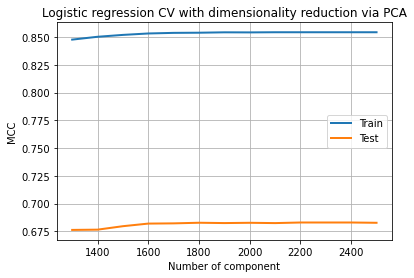

In [6]:
fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_mccs)], train_mccs, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_mccs)], test_mccs, linewidth=2.0, label='Test')
ax.set_title("Logistic regression CV with dimensionality reduction via PCA")
ax.set_xlabel("Number of component")
ax.set_ylabel("MCC")
ax.legend()
ax.grid()
fig.show()

C:\Users\Tony\AppData\Local\Temp\ipykernel_8080\103246462.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


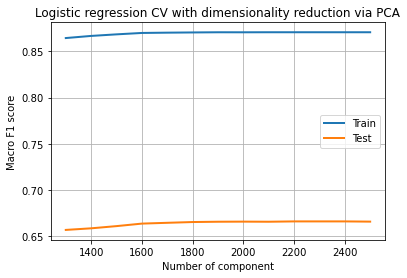

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_macro_f1_scores)], train_macro_f1_scores, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_macro_f1_scores)], test_macro_f1_scores, linewidth=2.0, label='Test')
ax.set_title("Logistic regression CV with dimensionality reduction via PCA")
ax.set_xlabel("Number of component")
ax.set_ylabel("Macro F1 score")
ax.legend()
ax.grid()
fig.show()

# Logistic regression with Kernel PCA (with different number of components)

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, matthews_corrcoef
import matplotlib.pyplot as plt

def matthews_corrcoef_wrapper(estimator, X, y):
    """This is a wrapper function to conform with the scoring
       argument for LogisticRegressionCV"""
    return matthews_corrcoef(y, estimator.predict(X))


train_macro_f1_scores = []
test_macro_f1_scores = []
train_mccs = []
test_mccs = []

n_components_list = np.arange(100,2600,100)

for n_components in n_components_list:
    print(F"Using {n_components} components from Kernel PCA...")
    
    pca = KernelPCA(n_components=n_components, 
                    kernel='rbf', 
                    n_jobs=-1, 
                    random_state=10,
                    eigen_solver="randomized")
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = LogisticRegressionCV(max_iter=1000000, 
                               class_weight='balanced',
                               scoring=matthews_corrcoef_wrapper,
                               solver='saga')
    clf.fit(X_train_pca, y_train)

    y_train_pred = clf.predict(X_train_pca)
    train_macro_f1_score = f1_score(y_train, y_train_pred, average="macro")
    train_macro_f1_scores.append(train_macro_f1_score)
    train_mcc = matthews_corrcoef(y_train, y_train_pred)
    train_mccs.append(train_mcc)
    
    
    y_test_pred = clf.predict(X_test_pca)
    test_macro_f1_score = f1_score(y_test, y_test_pred, average="macro")
    test_macro_f1_scores.append(test_macro_f1_score)
    test_mcc = matthews_corrcoef(y_test, y_test_pred)
    test_mccs.append(test_mcc)

    print(F"Train MCC:            {train_mcc}")
    print(F"Test MCC:             {test_mcc}")
    print(F"Train macro F1 score: {train_macro_f1_score}")
    print(F"Test macro F1 score:  {test_macro_f1_score}")
    print(F"-"*100)

    dataset_name = "dataset_00_all"
    result_filename = "result.json"
    model_name = F"00_kernel_pca_n_components={n_components}_logistic_regression_cv_defaults"

    make_classification_report(
        y_train,
        y_pred = y_train_pred,
        digits=4,
        label_encoder=enc,
        print_report=False,
        save_result=result_filename is not None,
        result_filename=result_filename,
        model_name=model_name,
        dataset_name=dataset_name,
        phase="train",
        repeat=True
    )

    make_classification_report(
        y_test,
        y_pred=y_test_pred,
        digits=4,
        label_encoder=enc,
        print_report=False,
        save_result=result_filename is not None,
        result_filename=result_filename,
        model_name=model_name,
        dataset_name=dataset_name,
        phase="test",
        repeat=True,
    )

Using 100 components from Kernel PCA...


In [ ]:
fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_mccs)], train_mccs, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_mccs)], test_mccs, linewidth=2.0, label='Test')
ax.set_title("Logistic regression CV with dimensionality reduction via Kernel PCA")
ax.set_xlabel("Number of component")
ax.set_ylabel("MCC")
ax.legend()
ax.grid()
fig.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_macro_f1_scores)], train_macro_f1_scores, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_macro_f1_scores)], test_macro_f1_scores, linewidth=2.0, label='Test')
ax.set_title("Logistic regression CV with dimensionality reduction via Kernel PCA")
ax.set_xlabel("Number of component")
ax.set_ylabel("Macro F1 score")
ax.legend()
ax.grid()
fig.show()

# FINAL

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import pickle

def matthews_corrcoef_wrapper(estimator, X, y):
    """This is a wrapper function to conform with the scoring
       argument for LogisticRegressionCV"""
    return matthews_corrcoef(y, estimator.predict(X))


pca = PCA(1000)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

clf = LogisticRegressionCV(max_iter=1000000, 
                           class_weight='balanced',
                           scoring=matthews_corrcoef_wrapper,
                           n_jobs=-1)
clf.fit(X_train_pca, y_train)

y_train_pred = clf.predict(X_train_pca)
train_macro_f1_score = f1_score(y_train, y_train_pred, average="macro")
train_mcc = matthews_corrcoef(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_pca)
test_macro_f1_score = f1_score(y_test, y_test_pred, average="macro")
test_mcc = matthews_corrcoef(y_test, y_test_pred)

print(F"Train MCC:            {train_mcc}")
print(F"Test MCC:             {test_mcc}")
print(F"Train macro F1 score: {train_macro_f1_score}")
print(F"Test macro F1 score:  {test_macro_f1_score}")
print(F"-"*100)

pickle.dump(pca, open("dataset_00_all_pca=1000.pickle", "wb"))
pickle.dump(clf, open("dataset_00_all_pca=1000_logistic_regression_cv.pickle", "wb"))

Train MCC:            0.7777435033799293
Test MCC:             0.6842615255694902
Train macro F1 score: 0.7795447169026221
Test macro F1 score:  0.6649473228776767
----------------------------------------------------------------------------------------------------


In [10]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, matthews_corrcoef
import pickle

def matthews_corrcoef_wrapper(estimator, X, y):
    """This is a wrapper function to conform with the scoring
       argument for LogisticRegressionCV"""
    return matthews_corrcoef(y, estimator.predict(X))

filepath = "dataset_00_all_pca=1000.pickle"
pca = pickle.load(open(filepath, 'rb'))

filepath = "dataset_00_all_pca=1000_logistic_regression_cv.pickle"
clf = pickle.load(open(filepath, 'rb'))

In [11]:
# https://vitalflux.com/validation-curves-explained-python-sklearn-example/

from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression

X_train_pca = pca.transform(X_train)

estimator = LogisticRegression(
    max_iter = 1000000, 
    class_weight = 'balanced')

vc_train_scores, vc_validation_scores = validation_curve(
    estimator = estimator,
    X = X_train_pca, 
    y = y_train,
    cv = 5,
    param_name = 'C', 
    param_range = clf.Cs_,
    scoring = matthews_corrcoef_wrapper,
    n_jobs = -1
)

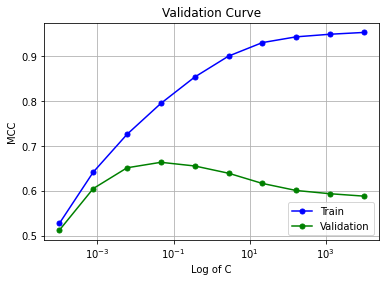

In [28]:
# validation curve

import matplotlib.pyplot as plt
import numpy as np


plt.plot(clf.Cs_, np.mean(vc_train_scores, axis=1),
         marker='o', markersize=5,
         color='blue', label='Train')
plt.plot(clf.Cs_, np.mean(vc_validation_scores, axis = 1),
         marker='o', markersize=5,
         color='green', label='Validation')
plt.title("Validation Curve")
plt.xlabel('Log of C')
plt.ylabel('MCC')
plt.xscale('log')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [13]:
# https://vitalflux.com/learning-curves-explained-python-sklearn-example/
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
import numpy as np

X_train_pca = pca.transform(X_train)
estimator = LogisticRegression(
    max_iter = 1000000, 
    class_weight = 'balanced',
    C = clf.C_[0]
)

lc_train_sizes, lc_train_scores, lc_test_scores = learning_curve(
    estimator = estimator, 
    X = X_train_pca, 
    y = y_train,
    cv = 5, 
    train_sizes = np.linspace(0.1, 1.0, 10),
    scoring = matthews_corrcoef_wrapper,
    n_jobs = -1
)

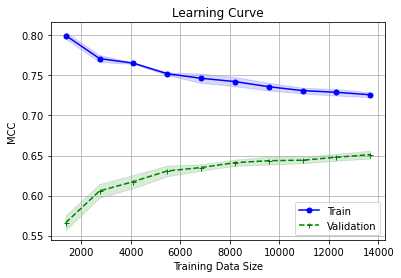

In [14]:
import matplotlib.pyplot as plt
import numpy as np
#
# Calculate training and test mean and std
#
lc_train_mean = np.mean(lc_train_scores, axis=1)
lc_train_std = np.std(lc_train_scores, axis=1)
lc_test_mean = np.mean(lc_test_scores, axis=1)
lc_test_std = np.std(lc_test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(lc_train_sizes, lc_train_mean, color='blue', marker='o', markersize=5, label='Train')
plt.fill_between(lc_train_sizes, lc_train_mean + lc_train_std, lc_train_mean - lc_train_std, alpha=0.15, color='blue')
plt.plot(lc_train_sizes, lc_test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation')
plt.fill_between(lc_train_sizes, lc_test_mean + lc_test_std, lc_test_mean - lc_test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('MCC')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [9]:
clf.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])